In this sheet I will apply Convolutional Neural Networks for stock prediction of S&P500 index. I will divide data from last 20 years into chunks. Every day contains four values: opening, low, high and closing ones - therefore input data for 30-day chunk has size 30x4. Predicted output has two classes: whether stock will go up or down or stay constant X days after last input.

In [27]:
OBSERVATION_TIME = 60
PREDICTION_AFTER_DAYS = 10
PERCENTAGE_THRESHOLD = 1
EPOCHS = 500
TEST_SIZE = 0.10
RANDOM_SPLIT = False

In [28]:
import pandas as pd
import numpy as np

df = pd.read_csv('./data/sp500_20Y_without_covid.csv')
df.reindex(index=df.index[::-1])

df.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-02-22,1346.089966,1358.109985,1331.880005,1352.170044,1352.170044,980000000
1,2000-02-23,1352.170044,1370.109985,1342.439941,1360.689941,1360.689941,993700000
2,2000-02-24,1360.689941,1364.800049,1329.880005,1353.430054,1353.430054,1215000000
3,2000-02-25,1353.430054,1362.140015,1329.150024,1333.359985,1333.359985,1065200000
4,2000-02-28,1333.359985,1360.819946,1325.069946,1348.050049,1348.050049,1026500000


In [29]:
def percentage_to_label(percentage_value):
    return 0 if percentage_value < 0 else 1

def investor_observes_stocks_for(x_days=60, then_buy_stocks=True, and_sells_them=True, after_y_days=10, dataframe=df):
    assert then_buy_stocks
    assert and_sells_them
    observe_buy_sell_process_length = x_days + after_y_days
    
    observed_chunks = []
    observation_results = []
    
    for first_day_of_observation in range(len(dataframe) - observe_buy_sell_process_length):
        buyout_day = first_day_of_observation + x_days
        sell_day = buyout_day + after_y_days
        
        observed_chunk = dataframe[first_day_of_observation:buyout_day].reset_index()
        observation_result = dataframe.iloc[sell_day]
        
        closing_price_on_buyout_day = dataframe.iloc[buyout_day]['Close']
        opening_price_on_sell_day = dataframe.iloc[sell_day]['Open']
        
        relative_price_change_as_percentage = (opening_price_on_sell_day - closing_price_on_buyout_day) / closing_price_on_buyout_day * 100
        
        observed_chunks += [observed_chunk]
        observation_results += [percentage_to_label(relative_price_change_as_percentage)]
    
    return observed_chunks, observation_results

observed_chunks, observation_results = investor_observes_stocks_for(x_days=OBSERVATION_TIME, then_buy_stocks=True, and_sells_them=True, after_y_days=PREDICTION_AFTER_DAYS)

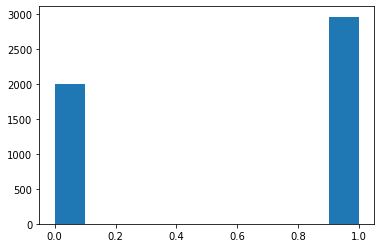

1    2957
0    2003
dtype: int64

In [30]:
import matplotlib.pyplot as plt

plt.hist(observation_results)
plt.show()

pd.Series(observation_results).value_counts()

**IMPORTANT NOTE** Selecting test/valiations chunks randomly from the whole set of observation chunks seems to be a big mistake. It causes situation where network actually seen chunks from the future, therefore the more overfitted network, the better results will be. Network should be trained incrementally - with data from time x to x+1 and validated with data from x+1 to x+2. Then learned with data from x to x+2 and validated with data from x+3 to x+3 and so on..

In [31]:
from keras import models
from keras.models import Sequential
from keras.layers import Convolution1D, MaxPooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.layers.core import Dense, Dropout, Activation, Flatten

model = Sequential()
model.add(Convolution1D(input_shape = (60, 5), filters=16, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(filters=8, kernel_size=4, padding='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 60, 16)            336       
_________________________________________________________________
batch_normalization_7 (Batch (None, 60, 16)            64        
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 60, 16)            0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 60, 16)            0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 60, 8)             520       
_________________________________________________________________
batch_normalization_8 (Batch (None, 60, 8)             32        
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 60, 8)            

In [32]:
from keras.optimizers import Nadam
import keras

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]


model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=METRICS)

In [33]:
from sklearn.model_selection import train_test_split

X = np.array(list(map(lambda df: df[['Open', 'High', 'Low', 'Close', 'Adj Close']].to_numpy(), observed_chunks)))
Y = np.array(observation_results).astype('float32')

def chronological_split(X_data, Y_data, test_size=0.25):
    training_test_split_index = int((1 - test_size) * len(X_data))
    X_train = X_data[:training_test_split_index]
    Y_train = Y_data[:training_test_split_index]
    X_test = X_data[training_test_split_index:]
    Y_test = Y_data[training_test_split_index:]
    return X_train, X_test, Y_train, Y_test
    
def random_split(X_data, Y_data, test_size=0.25):
    return train_test_split(X_data, Y_data, test_size=test_size, random_state=42)

X_train, X_test, Y_train, Y_test = random_split(X, Y, TEST_SIZE) if RANDOM_SPLIT else chronological_split(X, Y, TEST_SIZE)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((4464, 60, 5), (4464,), (496, 60, 5), (496,))

In [34]:
pd.Series(Y_test).value_counts()

1.0    334
0.0    162
dtype: int64

In [35]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath="model-binary.hdf5", save_best_only=True)

history = model.fit(x=X_train, 
                    y=Y_train, 
                    batch_size=128, 
                    epochs=EPOCHS, 
                    validation_data=(X_test, Y_test),
                    shuffle=True,
                    callbacks = [checkpointer])

Train on 4464 samples, validate on 496 samples
Epoch 1/500
4464/4464 [==============================] - 1s 211us/step - loss: 0.7471 - tp: 1374.0000 - fp: 1004.0000 - tn: 837.0000 - fn: 1249.0000 - accuracy: 0.4953 - precision: 0.5778 - recall: 0.5238 - auc: 0.4871 - val_loss: 1.4568 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4898
Epoch 2/500
4464/4464 [==============================] - 0s 74us/step - loss: 0.7064 - tp: 1977.0000 - fp: 1411.0000 - tn: 430.0000 - fn: 646.0000 - accuracy: 0.5392 - precision: 0.5835 - recall: 0.7537 - auc: 0.5026 - val_loss: 0.9018 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4557
Epoch 3/500
4464/4464 [==============================] - 0s 74us/step - loss: 0.7007 - tp: 2115.0000 - fp: 1476.0000 - tn: 365.0000 - fn: 508.0000 

4464/4464 [==============================] - 0s 67us/step - loss: 0.6764 - tp: 2579.0000 - fp: 1804.0000 - tn: 37.0000 - fn: 44.0000 - accuracy: 0.5860 - precision: 0.5884 - recall: 0.9832 - auc: 0.5361 - val_loss: 0.7167 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4644
Epoch 22/500
4464/4464 [==============================] - 0s 65us/step - loss: 0.6785 - tp: 2559.0000 - fp: 1789.0000 - tn: 52.0000 - fn: 64.0000 - accuracy: 0.5849 - precision: 0.5885 - recall: 0.9756 - auc: 0.5230 - val_loss: 0.7093 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4656
Epoch 23/500
4464/4464 [==============================] - 0s 64us/step - loss: 0.6774 - tp: 2602.0000 - fp: 1830.0000 - tn: 11.0000 - fn: 21.0000 - accuracy: 0.5853 - precision: 0.5871 - recall: 0.9920 - auc: 0.

4464/4464 [==============================] - 0s 65us/step - loss: 0.6748 - tp: 2618.0000 - fp: 1834.0000 - tn: 7.0000 - fn: 5.0000 - accuracy: 0.5880 - precision: 0.5881 - recall: 0.9981 - auc: 0.5408 - val_loss: 0.6461 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4516
Epoch 42/500
4464/4464 [==============================] - 0s 66us/step - loss: 0.6749 - tp: 2612.0000 - fp: 1832.0000 - tn: 9.0000 - fn: 11.0000 - accuracy: 0.5871 - precision: 0.5878 - recall: 0.9958 - auc: 0.5426 - val_loss: 0.6695 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4499
Epoch 43/500
4464/4464 [==============================] - 0s 66us/step - loss: 0.6754 - tp: 2616.0000 - fp: 1826.0000 - tn: 15.0000 - fn: 7.0000 - accuracy: 0.5894 - precision: 0.5889 - recall: 0.9973 - auc: 0.5378

4464/4464 [==============================] - 0s 65us/step - loss: 0.6746 - tp: 2554.0000 - fp: 1764.0000 - tn: 77.0000 - fn: 69.0000 - accuracy: 0.5894 - precision: 0.5915 - recall: 0.9737 - auc: 0.5472 - val_loss: 0.6653 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4580
Epoch 62/500
4464/4464 [==============================] - 0s 66us/step - loss: 0.6731 - tp: 2573.0000 - fp: 1806.0000 - tn: 35.0000 - fn: 50.0000 - accuracy: 0.5842 - precision: 0.5876 - recall: 0.9809 - auc: 0.5517 - val_loss: 0.6372 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4828
Epoch 63/500
4464/4464 [==============================] - 0s 69us/step - loss: 0.6736 - tp: 2573.0000 - fp: 1782.0000 - tn: 59.0000 - fn: 50.0000 - accuracy: 0.5896 - precision: 0.5908 - recall: 0.9809 - auc: 0.

4464/4464 [==============================] - 0s 65us/step - loss: 0.6722 - tp: 2541.0000 - fp: 1735.0000 - tn: 106.0000 - fn: 82.0000 - accuracy: 0.5930 - precision: 0.5942 - recall: 0.9687 - auc: 0.5558 - val_loss: 0.6455 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4752
Epoch 82/500
4464/4464 [==============================] - 0s 65us/step - loss: 0.6732 - tp: 2534.0000 - fp: 1726.0000 - tn: 115.0000 - fn: 89.0000 - accuracy: 0.5934 - precision: 0.5948 - recall: 0.9661 - auc: 0.5509 - val_loss: 0.6657 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4712
Epoch 83/500
4464/4464 [==============================] - 0s 65us/step - loss: 0.6734 - tp: 2521.0000 - fp: 1707.0000 - tn: 134.0000 - fn: 102.0000 - accuracy: 0.5948 - precision: 0.5963 - recall: 0.9611 - auc

4464/4464 [==============================] - 0s 66us/step - loss: 0.6711 - tp: 2476.0000 - fp: 1672.0000 - tn: 169.0000 - fn: 147.0000 - accuracy: 0.5925 - precision: 0.5969 - recall: 0.9440 - auc: 0.5639 - val_loss: 0.6422 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4641
Epoch 102/500
4464/4464 [==============================] - 0s 65us/step - loss: 0.6714 - tp: 2550.0000 - fp: 1740.0000 - tn: 101.0000 - fn: 73.0000 - accuracy: 0.5939 - precision: 0.5944 - recall: 0.9722 - auc: 0.5631 - val_loss: 0.6533 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4351
Epoch 103/500
4464/4464 [==============================] - 0s 63us/step - loss: 0.6715 - tp: 2539.0000 - fp: 1731.0000 - tn: 110.0000 - fn: 84.0000 - accuracy: 0.5934 - precision: 0.5946 - recall: 0.9680 - a

4464/4464 [==============================] - 0s 67us/step - loss: 0.6700 - tp: 2510.0000 - fp: 1685.0000 - tn: 156.0000 - fn: 113.0000 - accuracy: 0.5972 - precision: 0.5983 - recall: 0.9569 - auc: 0.5723 - val_loss: 0.6582 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4221
Epoch 122/500
4464/4464 [==============================] - 0s 67us/step - loss: 0.6723 - tp: 2469.0000 - fp: 1655.0000 - tn: 186.0000 - fn: 154.0000 - accuracy: 0.5948 - precision: 0.5987 - recall: 0.9413 - auc: 0.5625 - val_loss: 0.6441 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4570
Epoch 123/500
4464/4464 [==============================] - 0s 66us/step - loss: 0.6687 - tp: 2490.0000 - fp: 1643.0000 - tn: 198.0000 - fn: 133.0000 - accuracy: 0.6022 - precision: 0.6025 - recall: 0.9493 -

4464/4464 [==============================] - 0s 66us/step - loss: 0.6702 - tp: 2490.0000 - fp: 1687.0000 - tn: 154.0000 - fn: 133.0000 - accuracy: 0.5923 - precision: 0.5961 - recall: 0.9493 - auc: 0.5691 - val_loss: 0.6443 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4527
Epoch 142/500
4464/4464 [==============================] - 0s 65us/step - loss: 0.6694 - tp: 2504.0000 - fp: 1696.0000 - tn: 145.0000 - fn: 119.0000 - accuracy: 0.5934 - precision: 0.5962 - recall: 0.9546 - auc: 0.5718 - val_loss: 0.6446 - val_tp: 333.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 1.0000 - val_accuracy: 0.6714 - val_precision: 0.6727 - val_recall: 0.9970 - val_auc: 0.4540
Epoch 143/500
4464/4464 [==============================] - 0s 65us/step - loss: 0.6713 - tp: 2442.0000 - fp: 1627.0000 - tn: 214.0000 - fn: 181.0000 - accuracy: 0.5950 - precision: 0.6001 - recall: 0.9310 - auc

4464/4464 [==============================] - 0s 63us/step - loss: 0.6680 - tp: 2463.0000 - fp: 1624.0000 - tn: 217.0000 - fn: 160.0000 - accuracy: 0.6004 - precision: 0.6026 - recall: 0.9390 - auc: 0.5806 - val_loss: 0.6545 - val_tp: 332.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 2.0000 - val_accuracy: 0.6694 - val_precision: 0.6721 - val_recall: 0.9940 - val_auc: 0.4049
Epoch 162/500
4464/4464 [==============================] - 0s 64us/step - loss: 0.6701 - tp: 2443.0000 - fp: 1635.0000 - tn: 206.0000 - fn: 180.0000 - accuracy: 0.5934 - precision: 0.5991 - recall: 0.9314 - auc: 0.5734 - val_loss: 0.6537 - val_tp: 325.0000 - val_fp: 160.0000 - val_tn: 2.0000 - val_fn: 9.0000 - val_accuracy: 0.6593 - val_precision: 0.6701 - val_recall: 0.9731 - val_auc: 0.4698
Epoch 163/500
4464/4464 [==============================] - 0s 63us/step - loss: 0.6697 - tp: 2473.0000 - fp: 1659.0000 - tn: 182.0000 - fn: 150.0000 - accuracy: 0.5948 - precision: 0.5985 - recall: 0.9428 - auc: 0.5718

4464/4464 [==============================] - 0s 64us/step - loss: 0.6673 - tp: 2412.0000 - fp: 1589.0000 - tn: 252.0000 - fn: 211.0000 - accuracy: 0.5968 - precision: 0.6028 - recall: 0.9196 - auc: 0.5780 - val_loss: 0.6531 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4520
Epoch 182/500
4464/4464 [==============================] - 0s 65us/step - loss: 0.6671 - tp: 2433.0000 - fp: 1617.0000 - tn: 224.0000 - fn: 190.0000 - accuracy: 0.5952 - precision: 0.6007 - recall: 0.9276 - auc: 0.5819 - val_loss: 0.6570 - val_tp: 326.0000 - val_fp: 158.0000 - val_tn: 4.0000 - val_fn: 8.0000 - val_accuracy: 0.6653 - val_precision: 0.6736 - val_recall: 0.9760 - val_auc: 0.4680
Epoch 183/500
4464/4464 [==============================] - 0s 67us/step - loss: 0.6697 - tp: 2450.0000 - fp: 1638.0000 - tn: 203.0000 - fn: 173.0000 - accuracy: 0.5943 - precision: 0.5993 - recall: 0.9340 - auc: 0.

4464/4464 [==============================] - 0s 64us/step - loss: 0.6662 - tp: 2431.0000 - fp: 1598.0000 - tn: 243.0000 - fn: 192.0000 - accuracy: 0.5990 - precision: 0.6034 - recall: 0.9268 - auc: 0.5882 - val_loss: 0.7167 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4441
Epoch 202/500
4464/4464 [==============================] - 0s 65us/step - loss: 0.6698 - tp: 2373.0000 - fp: 1550.0000 - tn: 291.0000 - fn: 250.0000 - accuracy: 0.5968 - precision: 0.6049 - recall: 0.9047 - auc: 0.5729 - val_loss: 0.7220 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4577
Epoch 203/500
4464/4464 [==============================] - 0s 64us/step - loss: 0.6693 - tp: 2453.0000 - fp: 1626.0000 - tn: 215.0000 - fn: 170.0000 - accuracy: 0.5977 - precision: 0.6014 - recall: 0.9352 -

4464/4464 [==============================] - 0s 71us/step - loss: 0.6676 - tp: 2412.0000 - fp: 1586.0000 - tn: 255.0000 - fn: 211.0000 - accuracy: 0.5974 - precision: 0.6033 - recall: 0.9196 - auc: 0.5841 - val_loss: 0.6944 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4417
Epoch 222/500
4464/4464 [==============================] - 0s 69us/step - loss: 0.6684 - tp: 2396.0000 - fp: 1576.0000 - tn: 265.0000 - fn: 227.0000 - accuracy: 0.5961 - precision: 0.6032 - recall: 0.9135 - auc: 0.5771 - val_loss: 0.6479 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4579
Epoch 223/500
4464/4464 [==============================] - 0s 70us/step - loss: 0.6669 - tp: 2419.0000 - fp: 1586.0000 - tn: 255.0000 - fn: 204.0000 - accuracy: 0.5990 - precision: 0.6040 - recall: 0.9222 -

4464/4464 [==============================] - 0s 70us/step - loss: 0.6660 - tp: 2420.0000 - fp: 1580.0000 - tn: 261.0000 - fn: 203.0000 - accuracy: 0.6006 - precision: 0.6050 - recall: 0.9226 - auc: 0.5892 - val_loss: 0.8738 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4313
Epoch 242/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.6632 - tp: 2398.0000 - fp: 1561.0000 - tn: 280.0000 - fn: 225.0000 - accuracy: 0.5999 - precision: 0.6057 - recall: 0.9142 - auc: 0.5969 - val_loss: 0.7635 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4556
Epoch 243/500
4464/4464 [==============================] - 0s 69us/step - loss: 0.6663 - tp: 2378.0000 - fp: 1515.0000 - tn: 326.0000 - fn: 245.0000 - accuracy: 0.6057 - precision: 0.6108 - recall: 0.9066 -

4464/4464 [==============================] - 0s 72us/step - loss: 0.6644 - tp: 2403.0000 - fp: 1553.0000 - tn: 288.0000 - fn: 220.0000 - accuracy: 0.6028 - precision: 0.6074 - recall: 0.9161 - auc: 0.5927 - val_loss: 0.6832 - val_tp: 334.0000 - val_fp: 159.0000 - val_tn: 3.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6794 - val_precision: 0.6775 - val_recall: 1.0000 - val_auc: 0.4664
Epoch 262/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.6644 - tp: 2358.0000 - fp: 1525.0000 - tn: 316.0000 - fn: 265.0000 - accuracy: 0.5990 - precision: 0.6073 - recall: 0.8990 - auc: 0.5933 - val_loss: 0.6667 - val_tp: 305.0000 - val_fp: 149.0000 - val_tn: 13.0000 - val_fn: 29.0000 - val_accuracy: 0.6411 - val_precision: 0.6718 - val_recall: 0.9132 - val_auc: 0.4717
Epoch 263/500
4464/4464 [==============================] - 0s 69us/step - loss: 0.6651 - tp: 2424.0000 - fp: 1573.0000 - tn: 268.0000 - fn: 199.0000 - accuracy: 0.6030 - precision: 0.6065 - recall: 0.9241 - auc: 0.58

Epoch 282/500
4464/4464 [==============================] - 0s 70us/step - loss: 0.6616 - tp: 2390.0000 - fp: 1548.0000 - tn: 293.0000 - fn: 233.0000 - accuracy: 0.6010 - precision: 0.6069 - recall: 0.9112 - auc: 0.6061 - val_loss: 0.6978 - val_tp: 239.0000 - val_fp: 122.0000 - val_tn: 40.0000 - val_fn: 95.0000 - val_accuracy: 0.5625 - val_precision: 0.6620 - val_recall: 0.7156 - val_auc: 0.4349
Epoch 283/500
4464/4464 [==============================] - 0s 71us/step - loss: 0.6623 - tp: 2362.0000 - fp: 1488.0000 - tn: 353.0000 - fn: 261.0000 - accuracy: 0.6082 - precision: 0.6135 - recall: 0.9005 - auc: 0.6009 - val_loss: 0.6778 - val_tp: 288.0000 - val_fp: 154.0000 - val_tn: 8.0000 - val_fn: 46.0000 - val_accuracy: 0.5968 - val_precision: 0.6516 - val_recall: 0.8623 - val_auc: 0.4682
Epoch 284/500
4464/4464 [==============================] - 0s 70us/step - loss: 0.6654 - tp: 2383.0000 - fp: 1549.0000 - tn: 292.0000 - fn: 240.0000 - accuracy: 0.5992 - precision: 0.6061 - recall: 0.9085 

4464/4464 [==============================] - 0s 70us/step - loss: 0.6616 - tp: 2369.0000 - fp: 1463.0000 - tn: 378.0000 - fn: 254.0000 - accuracy: 0.6154 - precision: 0.6182 - recall: 0.9032 - auc: 0.6017 - val_loss: 0.6840 - val_tp: 331.0000 - val_fp: 158.0000 - val_tn: 4.0000 - val_fn: 3.0000 - val_accuracy: 0.6754 - val_precision: 0.6769 - val_recall: 0.9910 - val_auc: 0.4643
Epoch 303/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.6603 - tp: 2366.0000 - fp: 1449.0000 - tn: 392.0000 - fn: 257.0000 - accuracy: 0.6178 - precision: 0.6202 - recall: 0.9020 - auc: 0.6057 - val_loss: 0.6550 - val_tp: 332.0000 - val_fp: 160.0000 - val_tn: 2.0000 - val_fn: 2.0000 - val_accuracy: 0.6734 - val_precision: 0.6748 - val_recall: 0.9940 - val_auc: 0.4611
Epoch 304/500
4464/4464 [==============================] - 0s 69us/step - loss: 0.6622 - tp: 2350.0000 - fp: 1464.0000 - tn: 377.0000 - fn: 273.0000 - accuracy: 0.6109 - precision: 0.6162 - recall: 0.8959 - auc: 0.5974 - v

4464/4464 [==============================] - 0s 71us/step - loss: 0.6605 - tp: 2361.0000 - fp: 1473.0000 - tn: 368.0000 - fn: 262.0000 - accuracy: 0.6113 - precision: 0.6158 - recall: 0.9001 - auc: 0.6017 - val_loss: 0.9118 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4470
Epoch 323/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.6606 - tp: 2363.0000 - fp: 1441.0000 - tn: 400.0000 - fn: 260.0000 - accuracy: 0.6190 - precision: 0.6212 - recall: 0.9009 - auc: 0.6063 - val_loss: 0.6767 - val_tp: 298.0000 - val_fp: 156.0000 - val_tn: 6.0000 - val_fn: 36.0000 - val_accuracy: 0.6129 - val_precision: 0.6564 - val_recall: 0.8922 - val_auc: 0.4536
Epoch 324/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.6561 - tp: 2375.0000 - fp: 1455.0000 - tn: 386.0000 - fn: 248.0000 - accuracy: 0.6185 - precision: 0.6201 - recall: 0.9055 - auc: 0

Epoch 343/500
4464/4464 [==============================] - 0s 69us/step - loss: 0.6602 - tp: 2377.0000 - fp: 1441.0000 - tn: 400.0000 - fn: 246.0000 - accuracy: 0.6221 - precision: 0.6226 - recall: 0.9062 - auc: 0.6088 - val_loss: 0.9861 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4346
Epoch 344/500
4464/4464 [==============================] - 0s 69us/step - loss: 0.6574 - tp: 2363.0000 - fp: 1423.0000 - tn: 418.0000 - fn: 260.0000 - accuracy: 0.6230 - precision: 0.6241 - recall: 0.9009 - auc: 0.6130 - val_loss: 0.6849 - val_tp: 310.0000 - val_fp: 154.0000 - val_tn: 8.0000 - val_fn: 24.0000 - val_accuracy: 0.6411 - val_precision: 0.6681 - val_recall: 0.9281 - val_auc: 0.4685
Epoch 345/500
4464/4464 [==============================] - 0s 70us/step - loss: 0.6589 - tp: 2318.0000 - fp: 1461.0000 - tn: 380.0000 - fn: 305.0000 - accuracy: 0.6044 - precision: 0.6134 - recall: 0

4464/4464 [==============================] - 0s 68us/step - loss: 0.6554 - tp: 2305.0000 - fp: 1397.0000 - tn: 444.0000 - fn: 318.0000 - accuracy: 0.6158 - precision: 0.6226 - recall: 0.8788 - auc: 0.6204 - val_loss: 0.7350 - val_tp: 314.0000 - val_fp: 153.0000 - val_tn: 9.0000 - val_fn: 20.0000 - val_accuracy: 0.6512 - val_precision: 0.6724 - val_recall: 0.9401 - val_auc: 0.3798
Epoch 364/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.6538 - tp: 2347.0000 - fp: 1409.0000 - tn: 432.0000 - fn: 276.0000 - accuracy: 0.6225 - precision: 0.6249 - recall: 0.8948 - auc: 0.6208 - val_loss: 0.8488 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4590
Epoch 365/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.6593 - tp: 2279.0000 - fp: 1367.0000 - tn: 474.0000 - fn: 344.0000 - accuracy: 0.6167 - precision: 0.6251 - recall: 0.8689 - auc: 0

4464/4464 [==============================] - 0s 69us/step - loss: 0.6515 - tp: 2317.0000 - fp: 1347.0000 - tn: 494.0000 - fn: 306.0000 - accuracy: 0.6297 - precision: 0.6324 - recall: 0.8833 - auc: 0.6324 - val_loss: 0.9870 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4064
Epoch 384/500
4464/4464 [==============================] - 0s 67us/step - loss: 0.6529 - tp: 2333.0000 - fp: 1377.0000 - tn: 464.0000 - fn: 290.0000 - accuracy: 0.6266 - precision: 0.6288 - recall: 0.8894 - auc: 0.6264 - val_loss: 1.1629 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4220
Epoch 385/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.6538 - tp: 2298.0000 - fp: 1362.0000 - tn: 479.0000 - fn: 325.0000 - accuracy: 0.6221 - precision: 0.6279 - recall: 0.8761 -

4464/4464 [==============================] - 0s 64us/step - loss: 0.6514 - tp: 2322.0000 - fp: 1381.0000 - tn: 460.0000 - fn: 301.0000 - accuracy: 0.6232 - precision: 0.6271 - recall: 0.8852 - auc: 0.6267 - val_loss: 0.6905 - val_tp: 334.0000 - val_fp: 160.0000 - val_tn: 2.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6774 - val_precision: 0.6761 - val_recall: 1.0000 - val_auc: 0.4525
Epoch 404/500
4464/4464 [==============================] - 0s 64us/step - loss: 0.6505 - tp: 2294.0000 - fp: 1366.0000 - tn: 475.0000 - fn: 329.0000 - accuracy: 0.6203 - precision: 0.6268 - recall: 0.8746 - auc: 0.6309 - val_loss: 0.8342 - val_tp: 334.0000 - val_fp: 158.0000 - val_tn: 4.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6815 - val_precision: 0.6789 - val_recall: 1.0000 - val_auc: 0.4090
Epoch 405/500
4464/4464 [==============================] - 0s 63us/step - loss: 0.6521 - tp: 2275.0000 - fp: 1364.0000 - tn: 477.0000 - fn: 348.0000 - accuracy: 0.6165 - precision: 0.6252 - recall: 0.8673 - auc: 0.

Epoch 424/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.6464 - tp: 2301.0000 - fp: 1360.0000 - tn: 481.0000 - fn: 322.0000 - accuracy: 0.6232 - precision: 0.6285 - recall: 0.8772 - auc: 0.6361 - val_loss: 0.7389 - val_tp: 188.0000 - val_fp: 108.0000 - val_tn: 54.0000 - val_fn: 146.0000 - val_accuracy: 0.4879 - val_precision: 0.6351 - val_recall: 0.5629 - val_auc: 0.4231
Epoch 425/500
4464/4464 [==============================] - 0s 64us/step - loss: 0.6506 - tp: 2298.0000 - fp: 1370.0000 - tn: 471.0000 - fn: 325.0000 - accuracy: 0.6203 - precision: 0.6265 - recall: 0.8761 - auc: 0.6310 - val_loss: 0.8831 - val_tp: 334.0000 - val_fp: 161.0000 - val_tn: 1.0000 - val_fn: 0.0000e+00 - val_accuracy: 0.6754 - val_precision: 0.6747 - val_recall: 1.0000 - val_auc: 0.4667
Epoch 426/500
4464/4464 [==============================] - 0s 66us/step - loss: 0.6547 - tp: 2310.0000 - fp: 1359.0000 - tn: 482.0000 - fn: 313.0000 - accuracy: 0.6254 - precision: 0.6296 - recall: 0.8

4464/4464 [==============================] - 0s 77us/step - loss: 0.6487 - tp: 2289.0000 - fp: 1308.0000 - tn: 533.0000 - fn: 334.0000 - accuracy: 0.6322 - precision: 0.6364 - recall: 0.8727 - auc: 0.6372 - val_loss: 0.9045 - val_tp: 322.0000 - val_fp: 158.0000 - val_tn: 4.0000 - val_fn: 12.0000 - val_accuracy: 0.6573 - val_precision: 0.6708 - val_recall: 0.9641 - val_auc: 0.3965
Epoch 445/500
4464/4464 [==============================] - 0s 69us/step - loss: 0.6463 - tp: 2282.0000 - fp: 1325.0000 - tn: 516.0000 - fn: 341.0000 - accuracy: 0.6268 - precision: 0.6327 - recall: 0.8700 - auc: 0.6406 - val_loss: 0.7145 - val_tp: 301.0000 - val_fp: 153.0000 - val_tn: 9.0000 - val_fn: 33.0000 - val_accuracy: 0.6250 - val_precision: 0.6630 - val_recall: 0.9012 - val_auc: 0.4398
Epoch 446/500
4464/4464 [==============================] - 0s 70us/step - loss: 0.6452 - tp: 2264.0000 - fp: 1285.0000 - tn: 556.0000 - fn: 359.0000 - accuracy: 0.6317 - precision: 0.6379 - recall: 0.8631 - auc: 0.6417 -

Epoch 465/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.6409 - tp: 2226.0000 - fp: 1228.0000 - tn: 613.0000 - fn: 397.0000 - accuracy: 0.6360 - precision: 0.6445 - recall: 0.8486 - auc: 0.6517 - val_loss: 1.0385 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.4044
Epoch 466/500
4464/4464 [==============================] - 0s 67us/step - loss: 0.6419 - tp: 2268.0000 - fp: 1284.0000 - tn: 557.0000 - fn: 355.0000 - accuracy: 0.6328 - precision: 0.6385 - recall: 0.8647 - auc: 0.6493 - val_loss: 0.9427 - val_tp: 334.0000 - val_fp: 162.0000 - val_tn: 0.0000e+00 - val_fn: 0.0000e+00 - val_accuracy: 0.6734 - val_precision: 0.6734 - val_recall: 1.0000 - val_auc: 0.3977
Epoch 467/500
4464/4464 [==============================] - 0s 68us/step - loss: 0.6464 - tp: 2273.0000 - fp: 1329.0000 - tn: 512.0000 - fn: 350.0000 - accuracy: 0.6239 - precision: 0.6310 - re

4464/4464 [==============================] - 0s 66us/step - loss: 0.6402 - tp: 2236.0000 - fp: 1233.0000 - tn: 608.0000 - fn: 387.0000 - accuracy: 0.6371 - precision: 0.6446 - recall: 0.8525 - auc: 0.6546 - val_loss: 0.8812 - val_tp: 329.0000 - val_fp: 159.0000 - val_tn: 3.0000 - val_fn: 5.0000 - val_accuracy: 0.6694 - val_precision: 0.6742 - val_recall: 0.9850 - val_auc: 0.4568
Epoch 486/500
4464/4464 [==============================] - 0s 64us/step - loss: 0.6374 - tp: 2199.0000 - fp: 1204.0000 - tn: 637.0000 - fn: 424.0000 - accuracy: 0.6353 - precision: 0.6462 - recall: 0.8384 - auc: 0.6530 - val_loss: 0.7515 - val_tp: 331.0000 - val_fp: 158.0000 - val_tn: 4.0000 - val_fn: 3.0000 - val_accuracy: 0.6754 - val_precision: 0.6769 - val_recall: 0.9910 - val_auc: 0.4603
Epoch 487/500
4464/4464 [==============================] - 0s 63us/step - loss: 0.6408 - tp: 2275.0000 - fp: 1269.0000 - tn: 572.0000 - fn: 348.0000 - accuracy: 0.6378 - precision: 0.6419 - recall: 0.8673 - auc: 0.6504 - v

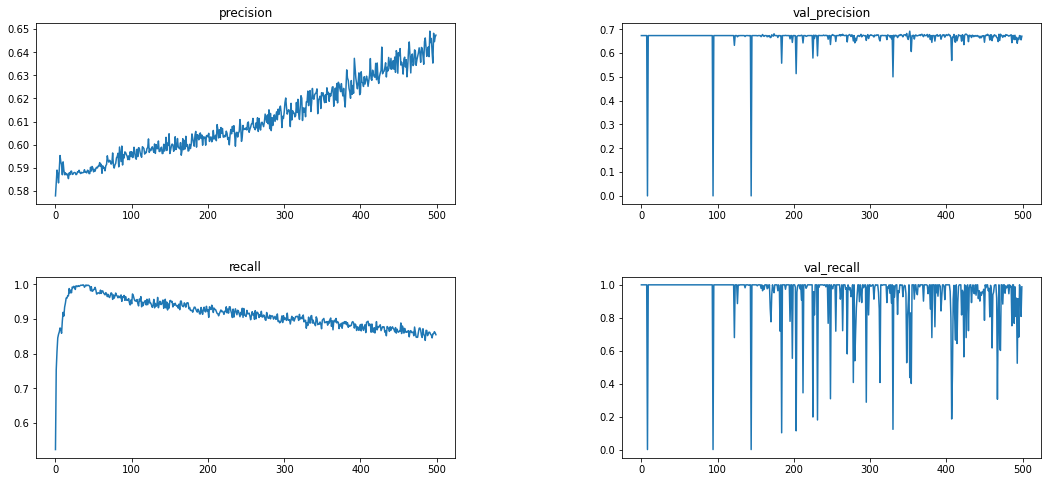

In [36]:
history_dict = history.history
history_dict.keys()

plotted_metrics = ['precision', 'recall']

fig = plt.figure(figsize=(18, 4 * len(plotted_metrics)))
fig.subplots_adjust(hspace=0.4, wspace=0.4)


for idx, metric in enumerate(plotted_metrics):
    plt.subplot(len(plotted_metrics), 2, 2*idx+1)
    plt.title(metric)
    plt.plot(history_dict[metric])
    
    plt.subplot(len(plotted_metrics), 2, 2*idx+2)
    plt.title('val_{}'.format(metric))
    plt.plot(history_dict['val_{}'.format(metric)])

plt.show()

In [ ]:
preds = 

In [15]:
pred_down_while_down = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 0 and x[1] == 0])
print('pred_down_while_down: ', pred_down_while_down)

pred_up_while_down = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 1 and x[1] == 0])
print('pred_up_while_down: ', pred_up_while_down)

NameError: name 'preds' is not defined

In [28]:
pred_down_while_up = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 0 and x[1] == 2])
print('pred_down_while_up: ', pred_down_while_up)

pred_steady_while_up = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 1 and x[1] == 2])
print('pred_steady_while_up: ', pred_steady_while_up)

pred_up_while_up = sum([1 for x in zip(np.argmax(preds, axis=1), labels) if x[0] == 2 and x[1] == 2])
print('pred_up_while_up: ', pred_up_while_up)

pred_down_while_up:  29
pred_steady_while_up:  240
pred_up_while_up:  518
